# Graphs in Postgres

Using `WITH RECURSIVE` CTE with `SEARCH` and `CYCLE` for graph evaluation in postgres 14+.

References:

* https://aiven.io/blog/explore-the-new-search-and-cycle-features-in-postgresql-14
* https://www.alibabacloud.com/blog/postgresql-recursive-query-examples-of-depth-first-and-breadth-first-search_599373
* https://www.fusionbox.com/blog/detail/graph-algorithms-in-a-database-recursive-ctes-and-topological-sort-with-postgres/620/
* https://aiven.io/blog/solving-the-knapsack-problem-in-postgresql
* https://www.alibabacloud.com/blog/postgresql-graph-search-practices---10-billion-scale-graph-with-millisecond-response_595039
* https://www.postgresql.org/docs/14/queries-with.html
* https://www.postgresql.org/docs/15/sql-select.html
* https://www.psycopg.org/psycopg3/docs/basic/usage.html



In [47]:
import psycopg
import graphviz

sql = [
"DROP TABLE IF EXISTS relation;",
"DROP TABLE IF EXISTS thing;",
"""CREATE TABLE thing (
    id VARCHAR PRIMARY KEY,
    thing_type VARCHAR,
    name VARCHAR
);""", 
"""CREATE TABLE relation (
    id int PRIMARY KEY,
    thing_a VARCHAR REFERENCES thing(id),
    thing_b VARCHAR REFERENCES thing(id),
    predicate VARCHAR
);""",
"""INSERT INTO thing VALUES 
  ('id01', 'sample', 'Sample 01'),
  ('id02', 'sample', 'Sample 02'),
  ('id03', 'sample', 'Sample 03'),
  ('id04', 'sample', 'Sample 04'),
  ('id05', 'sample', 'Sample 05'),
  ('id06', 'sample', 'Sample 06'),
  ('id07', 'actor', 'User 07'),
  ('id08', 'actor', 'User 08'),
  ('id09', 'actor', 'User 09');
""",
"""INSERT INTO relation VALUES 
  (0, 'id01', 'id07', 'creator'),
  (1, 'id01', 'id08', 'creator'),
  (2, 'id02', 'id08', 'creator'),
  (3, 'id03', 'id09', 'creator'),
  (4, 'id04', 'id09', 'creator'),
  (5, 'id05', 'id09', 'creator'),
  (6, 'id06', 'id09', 'creator'),
  (7, 'id02', 'id01', 'subsample_of'),
  (8, 'id03', 'id02', 'subsample_of');
"""
]

with psycopg.connect("dbname=thingtest user=vieglais") as cn:
    with cn.cursor() as csr:
        for s in sql:
            csr.execute(s)
            cn.commit()


def doquery(sql):
    with psycopg.connect("dbname=thingtest user=vieglais") as cn:
        with cn.cursor() as csr:
            result = csr.execute(sql).fetchall()
    return result

def node_label(n):
    return f"{n[0]} [label=\"" + "{" + "|".join(n) + "}\"]"

def show_graph(nodes, edges):
    dst = [
        "digraph {", 
        "node [shape=record, fontname=\"JetBrains Mono\", fontsize=10];",
    ]
    dst += [f"{node_label(node)};" for node in nodes]
    dst += [f"{edge};" for edge in edges]
    dst.append("}")
    print("\n".join(dst))
    return graphviz.Source("\n".join(dst))

In [48]:
q = """
with recursive full_thing(thing_id, rel_id, types, items) 
as (
  select 
    id as thing_id,
    null::int as rel_id,
    ARRAY[thing_type] as types,
    ARRAY[name] as items
  from thing
  where thing_type='sample'
  UNION ALL
  select
    relation.thing_b,
    relation.id,
    ft.types || thing_b.thing_type,
    ft.items || thing_b.name
  from full_thing ft 
    join relation on ft.thing_id = relation.thing_a
    join thing thing_a on relation.thing_a = thing_a.id
    join thing thing_b on relation.thing_b = thing_b.id
    where relation.predicate in ('creator')
)
SEARCH DEPTH FIRST BY thing_id SET ordercol
select * from full_thing order by ordercol;
"""
for row in doquery(q):
    print(row)

('id01', None, ['sample'], ['Sample 01'], [('id01',)])
('id07', 0, ['sample', 'actor'], ['Sample 01', 'User 07'], [('id01',), ('id07',)])
('id08', 1, ['sample', 'actor'], ['Sample 01', 'User 08'], [('id01',), ('id08',)])
('id02', None, ['sample'], ['Sample 02'], [('id02',)])
('id08', 2, ['sample', 'actor'], ['Sample 02', 'User 08'], [('id02',), ('id08',)])
('id03', None, ['sample'], ['Sample 03'], [('id03',)])
('id09', 3, ['sample', 'actor'], ['Sample 03', 'User 09'], [('id03',), ('id09',)])
('id04', None, ['sample'], ['Sample 04'], [('id04',)])
('id09', 4, ['sample', 'actor'], ['Sample 04', 'User 09'], [('id04',), ('id09',)])
('id05', None, ['sample'], ['Sample 05'], [('id05',)])
('id09', 5, ['sample', 'actor'], ['Sample 05', 'User 09'], [('id05',), ('id09',)])
('id06', None, ['sample'], ['Sample 06'], [('id06',)])
('id09', 6, ['sample', 'actor'], ['Sample 06', 'User 09'], [('id06',), ('id09',)])


digraph {
node [shape=record, fontname="JetBrains Mono", fontsize=10];
id01 [label="{id01|sample}"];
id02 [label="{id02|sample}"];
id03 [label="{id03|sample}"];
id04 [label="{id04|sample}"];
id05 [label="{id05|sample}"];
id06 [label="{id06|sample}"];
id07 [label="{id07|actor}"];
id08 [label="{id08|actor}"];
id09 [label="{id09|actor}"];
id01 -> id07 [label="creator"];
id01 -> id08 [label="creator"];
id02 -> id08 [label="creator"];
id03 -> id09 [label="creator"];
id04 -> id09 [label="creator"];
id05 -> id09 [label="creator"];
id06 -> id09 [label="creator"];
id02 -> id01 [label="subsample_of"];
id03 -> id02 [label="subsample_of"];
}


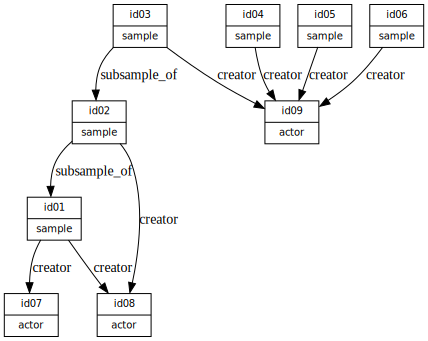

In [50]:
res = doquery("select id, thing_type from thing;")
nodes = [(n[0], n[1]) for n in res]
res = doquery("select id, thing_a, thing_b, predicate from relation;")
edges = [f"{e[1]} -> {e[2]} [label=\"{e[3]}\"]" for e in res]
show_graph(nodes, edges)

In [70]:
q = """
SELECT 
    src.id AS thing_a,
    src.thing_type AS t_type,
    relation.id AS rel_id,
    relation.predicate AS predicate,
    dst.id AS thing_b
FROM thing src
    JOIN relation ON src.id = relation.thing_a
    JOIN thing dst ON relation.thing_b = dst.id
WHERE src.id = 'id01';
"""

for row in doquery(q):
    print(row)

('id01', 'sample', 0, 'creator', 'id07')
('id01', 'sample', 1, 'creator', 'id08')


In [160]:
qa = """
WITH RECURSIVE related (thing_a, predicate, thing_b) AS (
    SELECT relation.thing_a, relation.predicate, relation.thing_b
    FROM relation
    WHERE relation.thing_a = 'id03'
UNION
    SELECT relation.thing_a, relation.predicate, relation.thing_b
    FROM relation
    JOIN related ON relation.thing_a = related.thing_b
)
"""
q = qa + "SELECT * FROM related"
for row in doquery(q):
    print(row)
print("===")
q = qa + """
SELECT related.thing_a, ta.thing_type, related.predicate, related.thing_b, tb.thing_type
FROM related
JOIN thing ta ON related.thing_a = ta.id
JOIN thing tb ON related.thing_b = tb.id
"""
for row in doquery(q):
    print(row)



('id03', 'creator', 'id09')
('id03', 'subsample_of', 'id02')
('id02', 'creator', 'id08')
('id02', 'subsample_of', 'id01')
('id01', 'creator', 'id07')
('id01', 'creator', 'id08')
===
('id03', 'sample', 'creator', 'id09', 'actor')
('id03', 'sample', 'subsample_of', 'id02', 'sample')
('id02', 'sample', 'creator', 'id08', 'actor')
('id02', 'sample', 'subsample_of', 'id01', 'sample')
('id01', 'sample', 'creator', 'id07', 'actor')
('id01', 'sample', 'creator', 'id08', 'actor')


In [130]:
# All things related to id03
q = """
WITH RECURSIVE full_thing(a_id, rel_id, predicate, b_id) 
AS (
  SELECT 
    r.thing_a AS a_id,
    r.id AS rel_id,
    r.predicate,
    r.thing_b as b_id
  FROM relation r
  WHERE r.thing_a='id03'
  UNION ALL
  SELECT
    r.thing_a,
    r.id,
    r.predicate,
    r.thing_b
  FROM relation r, full_thing ft 
  WHERE r.thing_a = ft.b_id
)
SELECT * FROM full_thing ft;
"""
for row in doquery(q):
    print(row)

('id03', 3, 'creator', 'id09')
('id03', 8, 'subsample_of', 'id02')
('id02', 2, 'creator', 'id08')
('id02', 7, 'subsample_of', 'id01')
('id01', 0, 'creator', 'id07')
('id01', 1, 'creator', 'id08')


In [144]:
# All things related to id03
q = """
WITH RECURSIVE full_thing(a_id, a_type, rel_id, predicate, b_id) 
AS (
  SELECT 
    t.id AS a_id,
    t.thing_type as a_type,
    r.id AS rel_id,
    r.predicate,
    r.thing_b as b_id
  FROM thing t
  JOIN relation r ON r.thing_a = t.id
  WHERE t.id = 'id03'
  UNION ALL
  SELECT
    t.id,
    t.thing_type,
    r.id,
    r.predicate,
    r.thing_b
  FROM thing t, full_thing ft 
  JOIN relation r on r.thing_a = ft.b_id
  WHERE t.id = ft.b_id
)
SELECT ft.a_id, ft.a_type, ft.rel_id, ft.predicate, ft.b_id, t.thing_type 
FROM full_thing ft
JOIN thing t ON ft.b_id=t.id;
"""
for row in doquery(q):
    print(row)

('id03', 'sample', 3, 'creator', 'id09', 'actor')
('id03', 'sample', 8, 'subsample_of', 'id02', 'sample')
('id02', 'sample', 2, 'creator', 'id08', 'actor')
('id02', 'sample', 7, 'subsample_of', 'id01', 'sample')
('id01', 'sample', 0, 'creator', 'id07', 'actor')
('id01', 'sample', 1, 'creator', 'id08', 'actor')


In [79]:
q = """
WITH RECURSIVE full_thing(thing_a, t_type, rel_id, predicate, thing_b) 
AS (
  SELECT 
    id AS thing_a,
    thing_type AS t_type,
    null::int AS rel_id,
    null::varchar AS predicate,
    null::varchar AS thing_b
  FROM thing
  WHERE id='id03'
  UNION ALL
  SELECT
    thing_a.id,
    thing_a.thing_type,
    relation.id,
    relation.predicate,
    relation.thing_a
  FROM full_thing ft 
    JOIN relation ON ft.thing_a = relation.thing_a
    JOIN thing thing_a ON relation.thing_b = thing_a.id
    -- JOIN thing thing_b ON relation.thing_b = thing_b.id
    --where relation.predicate in ('creator')
)
SELECT * FROM full_thing;
"""
for row in doquery(q):
    print(row)

('id03', 'sample', None, None, None)
('id09', 'actor', 3, 'creator', 'id03')
('id02', 'sample', 8, 'subsample_of', 'id03')
('id08', 'actor', 2, 'creator', 'id02')
('id01', 'sample', 7, 'subsample_of', 'id02')
('id07', 'actor', 0, 'creator', 'id01')
('id08', 'actor', 1, 'creator', 'id01')
